In [1]:
%pip install -r "../requirements.txt"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os

import pandas as pd
import numpy as np

# Assumes notebook is in 'notebooks/' and src is in 'src/'
sys.path.append(os.path.abspath('..'))

from src.loaders import load_2lead_ecg
import matplotlib.pyplot as plt

In [3]:
# --- CONFIGURATION ---

# Choose a Patient ID that is INSIDE that file range (e.g., 4007, 4008, or 4009)
target_pid = 4001 

# Path relative to the notebook folder
sqlite_path = "../data/raw/2_lead_ecg/4001-4006.sqlite3"
dcm_path = f"../data/raw/12_lead_ecg/{target_pid}.dcm" 

output_folder = "../data/processed/"

Loading Patient 4001...
⚠️ WARNING: Count Mismatch in 4001-4006.sqlite3!
   Expected 6 patients ([4001, 4002, 4003, 4004, 4005, 4006])
   Found 5 distinct recordings in DB.
   Mapping is likely UNRELIABLE. Proceeding by index assumption...
✅ Success!
Sampling Rate: 1024.0 Hz
Total Samples: 229000
Calculated Duration: 223.63 seconds
Time delta between samples: 0.000976 sec (Expected: 0.000977)


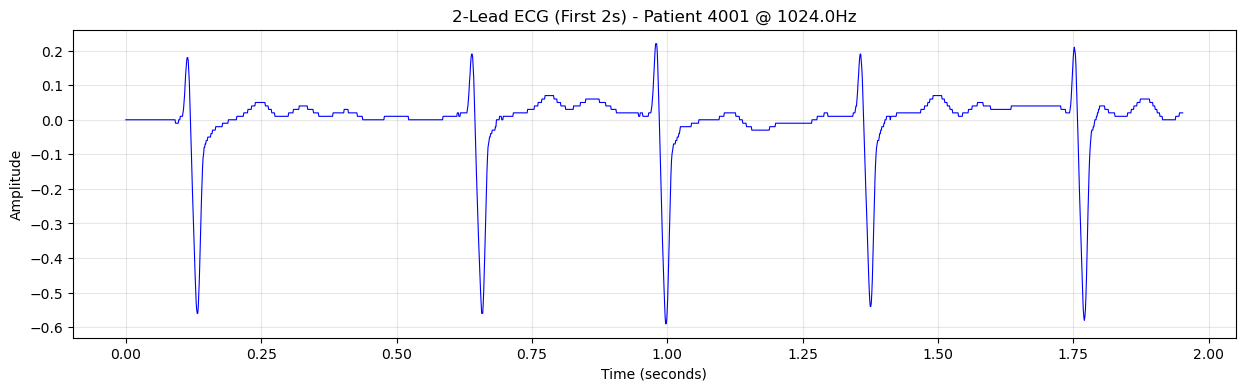

In [4]:
print(f"Loading Patient {target_pid}...")
df_2lead = load_2lead_ecg(sqlite_path, target_pid)

if df_2lead is not None:
    print("✅ Success!")
    
    # Check Metadata
    fs = df_2lead.attrs.get('sampling_rate', 'Unknown')
    print(f"Sampling Rate: {fs} Hz")
    
    # Calculate duration based on FS
    duration_sec = len(df_2lead) / fs
    print(f"Total Samples: {len(df_2lead)}")
    print(f"Calculated Duration: {duration_sec:.2f} seconds")
    
    # Verify Time Delta
    # The difference between two consecutive samples should be 1/1024 = ~0.000976 seconds
    if len(df_2lead) > 1:
        dt = (df_2lead['timestamp'].iloc[1] - df_2lead['timestamp'].iloc[0]).total_seconds()
        print(f"Time delta between samples: {dt:.6f} sec (Expected: {1/1024:.6f})")

    # Plot
    plt.figure(figsize=(15, 4))
    # Construct a time axis using the sampling rate for x-axis
    time_axis = np.arange(len(df_2lead)) / fs
    
    plt.plot(time_axis[:2000], df_2lead['ecg_value'].iloc[:2000], color='blue', linewidth=0.8)
    plt.title(f"2-Lead ECG (First 2s) - Patient {target_pid} @ {fs}Hz")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("❌ Failed to load.")

⚠️ WARNING: Count Mismatch in 4001-4006.sqlite3!
   Expected 6 patients ([4001, 4002, 4003, 4004, 4005, 4006])
   Found 5 distinct recordings in DB.
   Mapping is likely UNRELIABLE. Proceeding by index assumption...

Time Gap Stats:
Mean: 0.976562 ms (Expected: 0.976562)
Std Dev: 0.0000005039 ms (Should be ~0.0)


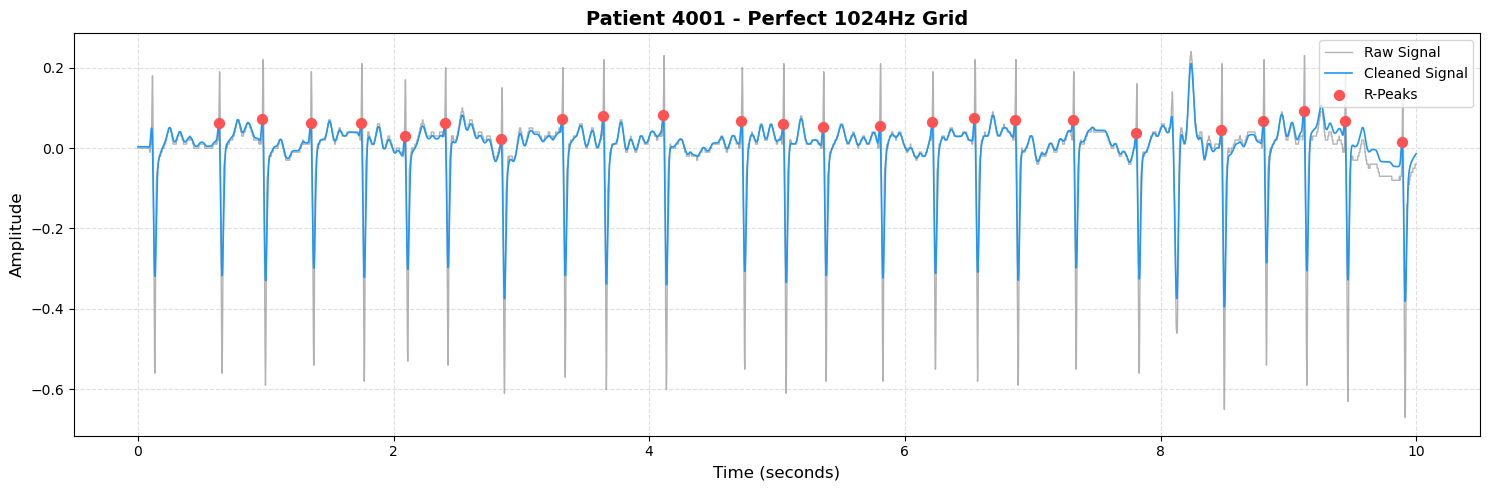

In [5]:
# 2-lead Pipeline Test

from src import load_2lead_ecg, process_ecg, save_processed_ecg, plot_ecg_analysis
import numpy as np

# 1. Load (New Logic)
df = load_2lead_ecg(sqlite_path, target_pid)

if df is not None:
    # Verify Statistics
    time_diffs_ms = df['timestamp'].diff().dt.total_seconds() * 1000
    expected_dt_ms = (1.0/1024) * 1000
    
    print(f"\nTime Gap Stats:")
    print(f"Mean: {time_diffs_ms.mean():.6f} ms (Expected: {expected_dt_ms:.6f})")
    print(f"Std Dev: {time_diffs_ms.std():.10f} ms (Should be ~0.0)")
    
    # Process & Visualize
    from src.processors import process_ecg
    from src.utils import plot_ecg_analysis
    
    result = process_ecg(df['ecg_value'].values, fs=1024)
    
    if result:
        plot_ecg_analysis(
            signal=df['ecg_value'].values,
            fs=1024,
            cleaned_signal=result['cleaned_signal'],
            r_peaks=result['r_peaks'],
            title=f"Patient {target_pid} - Perfect 1024Hz Grid",
            duration_sec=10
        )


Loaded 12-Lead. FS: 1000.0 Hz. Duration: 24.0s
✓ Saved 12-lead plot to ../data/processed/plots/patient_4001_12lead_grid.png


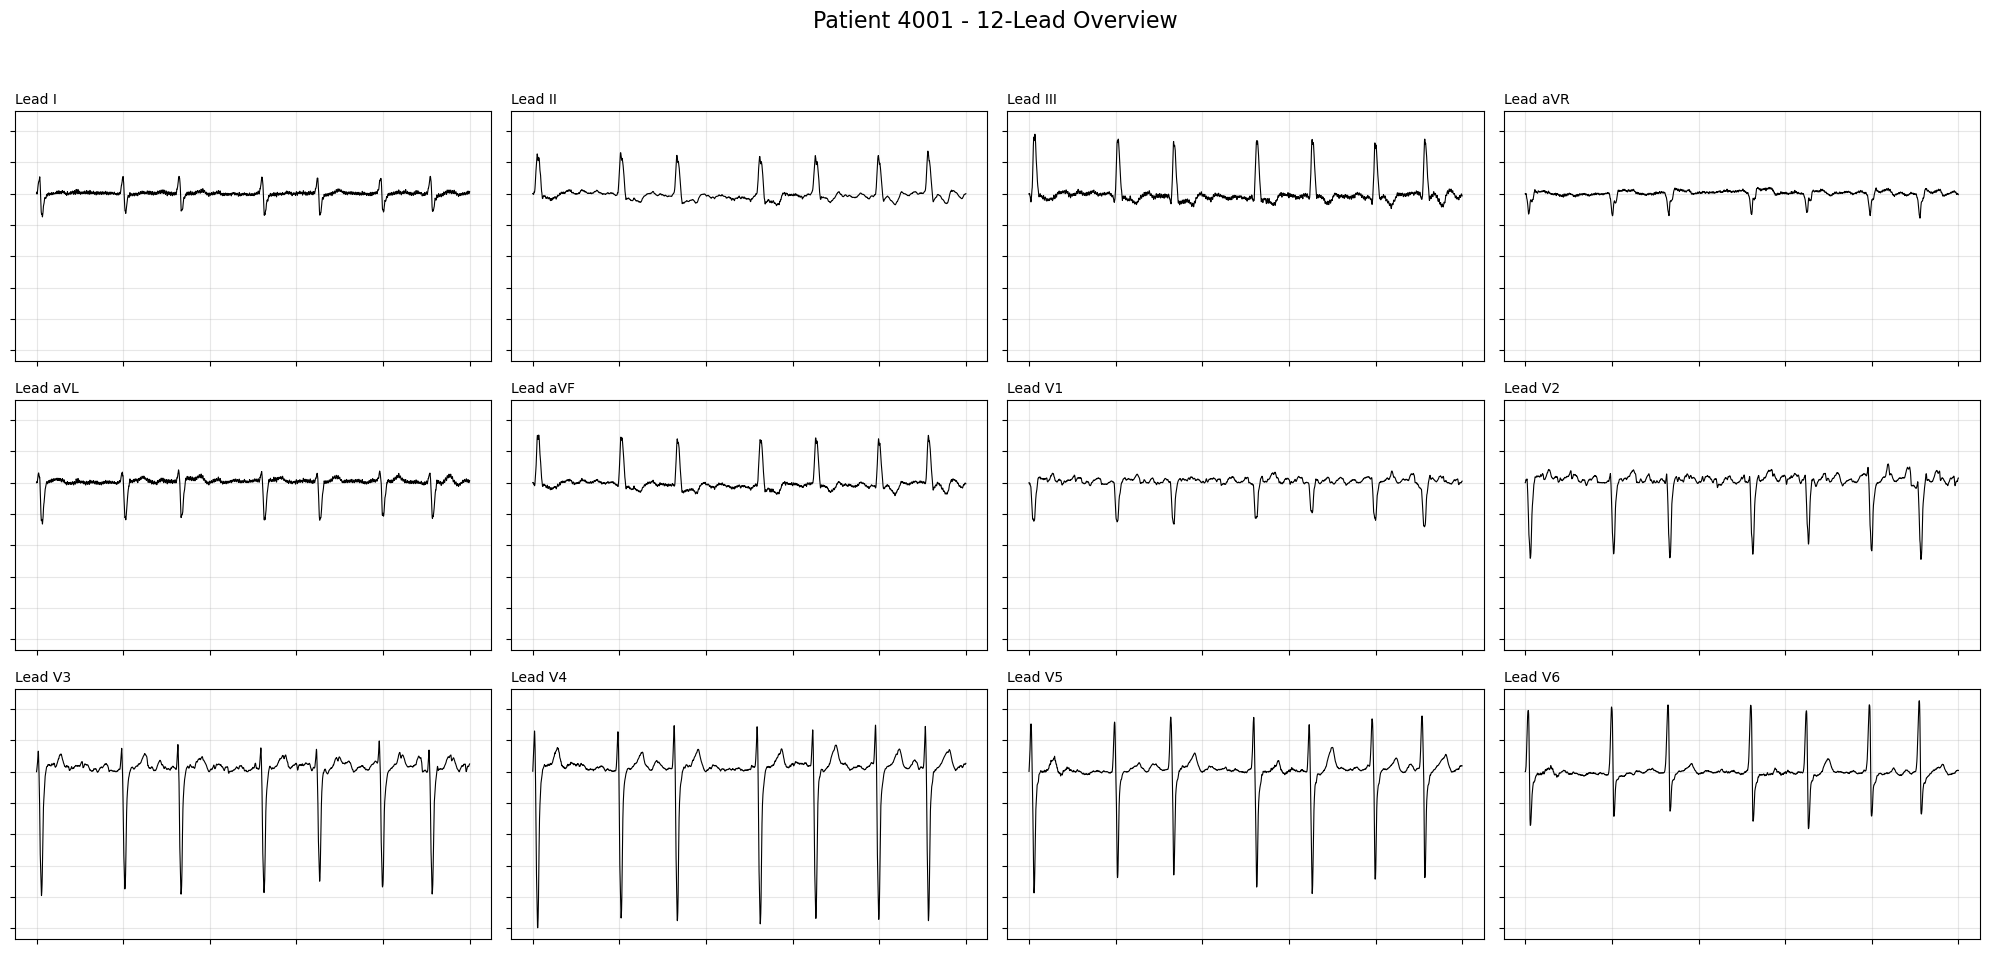


Processing Rhythm Strip (Lead II)...
✓ Plot saved to ../data/processed/plots/patient_4001_LeadII.png


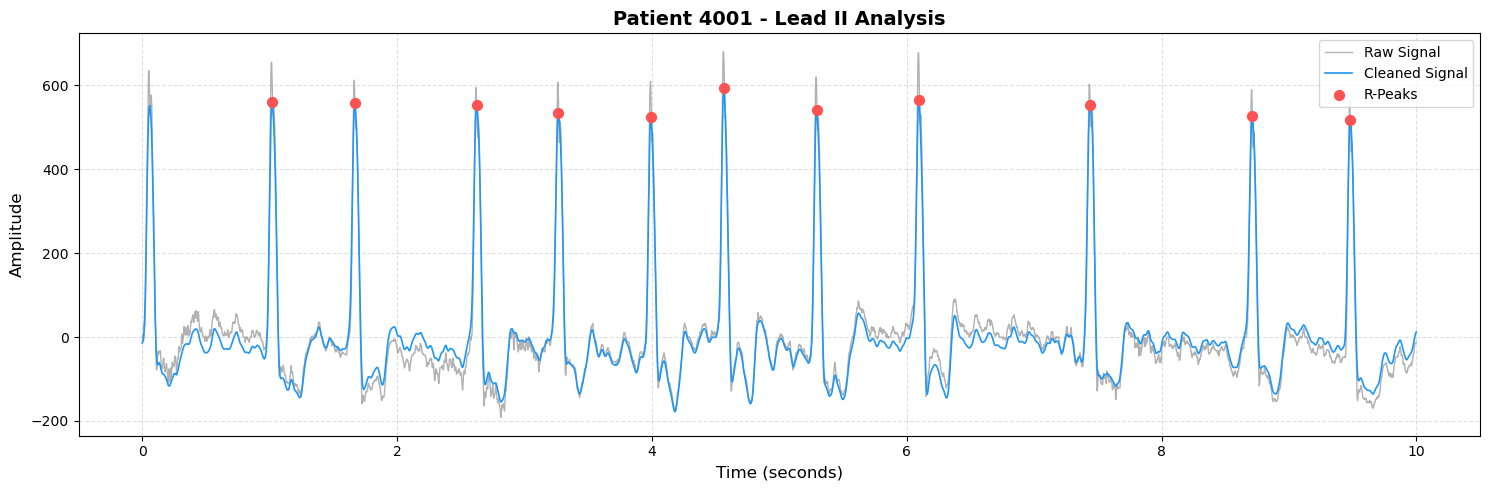


Rhythm Metrics (Lead II):
  HR: 83.4 bpm
  RMSSD: 181.0 ms


In [6]:
# 12-Lead Pipeline Test

from src import load_dicom_12lead, process_ecg, plot_ecg_analysis, plot_12lead_grid
import pandas as pd
import numpy as np
import os

# CONFIG
target_pid = "4001" # Or extract from filename
dicom_path = f"../data/raw/12_lead_ecg/{target_pid}.dcm" 

# 1. Load
result_dict = load_dicom_12lead(dicom_path)

if result_dict is not None:
    signals_df = result_dict['signals']
    meta = result_dict['metadata']
    fs = meta['sampling_rate']
    
    print(f"Loaded 12-Lead. FS: {fs} Hz. Duration: {meta['duration_sec']}s")
    
    # 2. Visualize Overview (Grid Plot)
    # This gives you a quick look at signal quality across all leads
    plot_12lead_grid(
        signals_df, 
        fs, 
        title=f"Patient {target_pid} - 12-Lead Overview",
        save_path=f"../data/processed/plots/patient_{target_pid}_12lead_grid.png"
    )

    # 3. Process Rhythm Strip (Lead II)
    # Standard practice: Use Lead II for HR/HRV metrics
    target_lead = 'Lead II'
    if target_lead in signals_df.columns:
        print(f"\nProcessing Rhythm Strip ({target_lead})...")
        
        raw_rhythm = signals_df[target_lead].values
        
        # Process (Same function as 2-lead!)
        rhythm_result = process_ecg(raw_rhythm, fs=fs)
        
        if rhythm_result:
            # Visualize Detailed Rhythm (Clean + Peaks)
            # Re-using the same function as 2-lead for consistency
            plot_ecg_analysis(
                signal=raw_rhythm,
                fs=fs,
                cleaned_signal=rhythm_result['cleaned_signal'],
                r_peaks=rhythm_result['r_peaks'],
                title=f"Patient {target_pid} - {target_lead} Analysis",
                save_path=f"../data/processed/plots/patient_{target_pid}_{target_lead.replace(' ', '')}.png",
                duration_sec=10
            )
            
            # Print Metrics
            m = rhythm_result['metrics']
            print("\nRhythm Metrics (Lead II):")
            print(f"  HR: {m['hr_mean']:.1f} bpm")
            print(f"  RMSSD: {m['rmssd_ms']:.1f} ms")
            
    else:
        print(f"Lead {target_lead} not found in file.")

else:
    print("Loading failed.")

/Users/soonheekim/Desktop/FYP/Code_v01/src/loaders.py:223: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read(filepath)


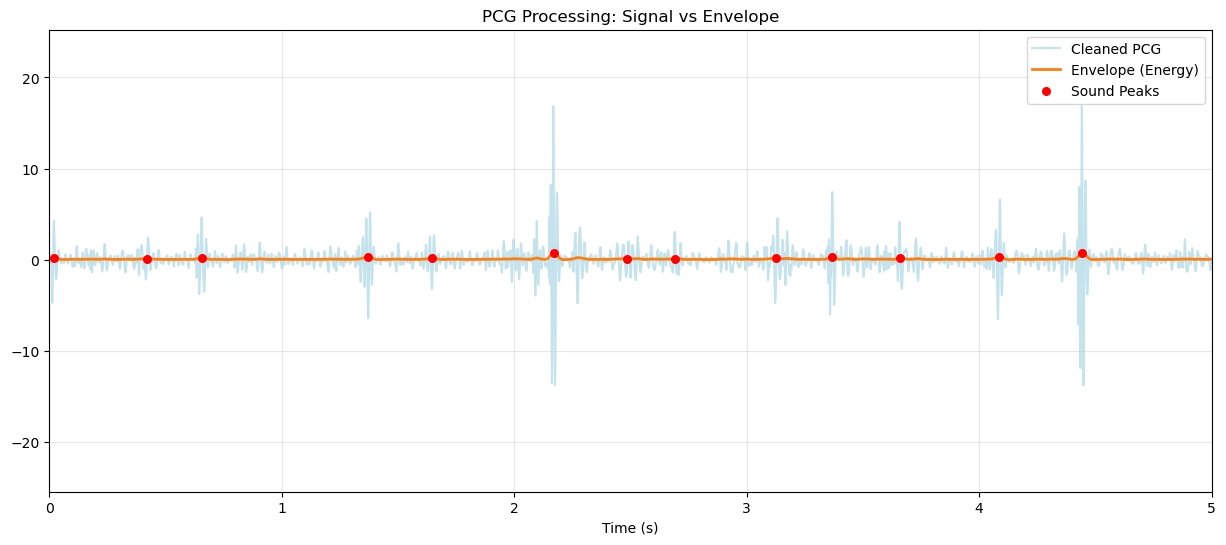

Metrics: {'duration_sec': 120.91065759637188, 'rms_energy': 0.9827214478117186, 'num_peaks_detected': 267, 'mfcc_1': -172.18740179008856, 'mfcc_2': 77.66514114360457, 'mfcc_3': 69.75296676006305, 'mfcc_4': 58.18322590095918, 'mfcc_5': 44.946506070927335, 'mfcc_6': 32.09848519211403, 'mfcc_7': 21.303090706457148, 'mfcc_8': 13.526935564336215, 'mfcc_9': 8.95123993912266, 'mfcc_10': 7.093880833598764, 'mfcc_11': 7.07243292372673, 'mfcc_12': 7.908727111057204, 'mfcc_13': 8.782154600371484}


In [7]:
# iPhone Audio Loader Pipeline Test
from src.loaders import load_iphone_wav
from src.processors import process_pcg
from IPython.display import display, Audio

# CONFIG
wav_path = "../data/raw/ausc_iphone/iData4001M.wav" # Update path

# 1. Load
data = load_iphone_wav(wav_path)

if data:
    fs = data['fs']
    
    # 2. Process
    pcg_result = process_pcg(data['signal'], fs)
    
    # 3. Visualize
    t = np.arange(len(pcg_result['cleaned_signal'])) / fs
    
    plt.figure(figsize=(15, 6))
    
    # Plot Cleaned Signal (Light Blue)
    plt.plot(t, pcg_result['cleaned_signal'], color='lightblue', label='Cleaned PCG', alpha=0.7)
    
    # Plot Envelope (Orange - The Sync Signal)
    plt.plot(t, pcg_result['envelope'], color='#ff7f0e', label='Envelope (Energy)', linewidth=2)
    
    # Plot Detected Peaks (Red Dots)
    peaks = pcg_result['peaks']
    plt.scatter(t[peaks], pcg_result['envelope'][peaks], color='red', s=30, label='Sound Peaks', zorder=5)
    
    plt.title("PCG Processing: Signal vs Envelope")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.xlim(0, 5) # Zoom first 5s
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Metrics:", pcg_result['metrics'])

Loading ../data/raw/ausc_pin/4001 audio_data_2025-08-27_15-46-43.csv...
✅ Loaded successfully!
Start Time: 2025-08-27 15:46:43
Duration: 121.17 seconds (at 12000 Hz)
Raw Amplitude Range: [-69.0, 70.0]

Processing...
Detected 486 peaks.
Estimated HR (Proxy): 240.4 bpm
⚠️ Warning: HR seems unrealistic. Check Sampling Rate (fs).


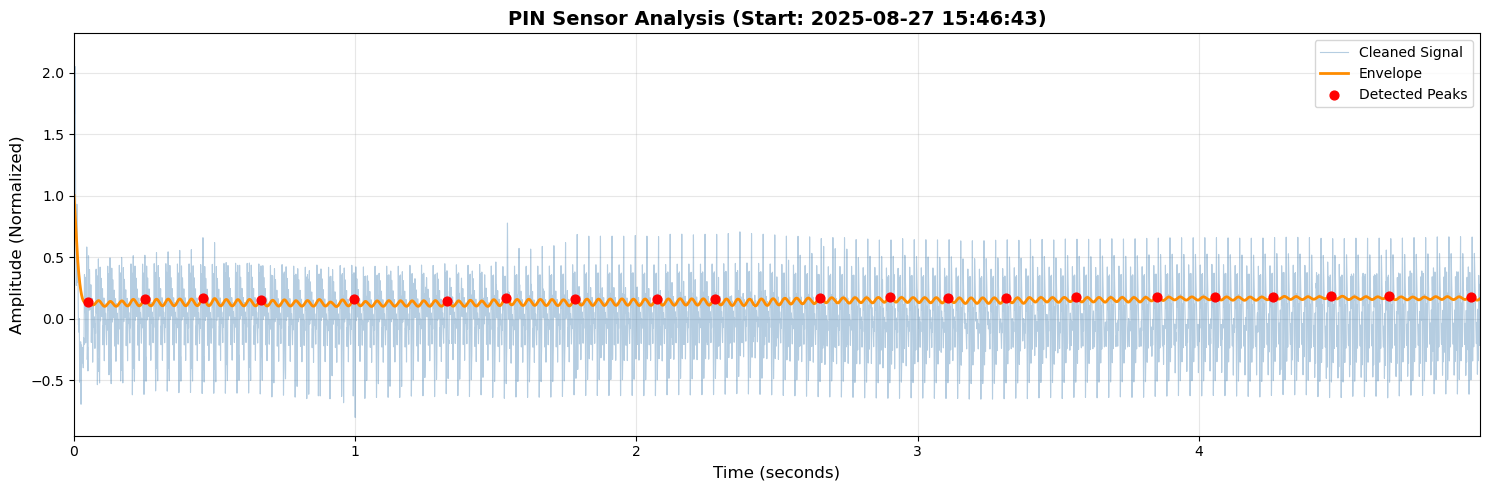

In [14]:
# Cell: Test PIN CSV Loading & Processing

from src import load_pin_csv, process_pcg, plot_pcg_result
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
csv_path = "../data/raw/ausc_pin/4001 audio_data_2025-08-27_15-46-43.csv"
ASSUMED_FS = 12000  # calculated @ https://colab.research.google.com/drive/1HYt4HPi00wK3_LebIgIzDDZre4PKypCS?usp=sharing

# 1. Load (With Filename Parsing)
print(f"Loading {csv_path}...")
pin_data = load_pin_csv(csv_path, fs=ASSUMED_FS)

if pin_data is not None:
    signal = pin_data['signal']
    timestamps = pin_data['timestamps']
    meta = pin_data['metadata']
    
    print("✅ Loaded successfully!")
    print(f"Start Time: {meta['start_time']}")
    print(f"Duration: {meta['total_samples'] / ASSUMED_FS:.2f} seconds (at {ASSUMED_FS} Hz)")
    print(f"Raw Amplitude Range: [{signal.min()}, {signal.max()}]")
    
    # 2. Process (Standardize -> Filter -> Envelope -> Peaks)
    print("\nProcessing...")
    result = process_pcg(signal, fs=ASSUMED_FS)
    
    # Check if we found peaks
    n_peaks = result['metrics']['num_peaks_detected']
    print(f"Detected {n_peaks} peaks.")
    
    # Calculate approximate Heart Rate from peaks to verify FS
    if n_peaks > 1:
        peak_diffs = np.diff(result['peaks']) / ASSUMED_FS
        avg_hr = 60 / np.mean(peak_diffs)
        print(f"Estimated HR (Proxy): {avg_hr:.1f} bpm")
        
        if avg_hr < 30 or avg_hr > 200:
            print("⚠️ Warning: HR seems unrealistic. Check Sampling Rate (fs).")
    
    # 3. Visualize
    plot_pcg_result(
        signal=signal,
        fs=ASSUMED_FS,
        result=result,
        title=f"PIN Sensor Analysis (Start: {meta['start_time']})",
        duration_sec=5, # Zoom to first 5s to see morphology
        decimate=1
    )

else:
    print("❌ Failed to load CSV.")

In [18]:
# Cell: Compare Raw vs Processed Audio

import scipy.io.wavfile as wav
import numpy as np
from IPython.display import Audio, display

def save_and_play(signal, fs, label):
    # Normalize to Int16
    sig_centered = signal - np.mean(signal)
    max_val = np.max(np.abs(sig_centered))
    if max_val > 0:
        # Scale to ~90% of max volume
        audio_int16 = (sig_centered * (30000 / max_val)).astype(np.int16)
    else:
        audio_int16 = sig_centered.astype(np.int16)
        
    filename = f"audio_{label.lower().replace(' ', '_')}.wav"
    wav.write(filename, fs, audio_int16)
    
    print(f"🔊 {label} ({fs} Hz):")
    display(Audio(data=audio_int16, rate=fs))

# 1. Raw (Noisy, Clicky)
if 'pin_data' in locals():
    print("--- 1. Raw Input ---")
    save_and_play(pin_data['signal'], pin_data['fs'], "Raw Signal")

# 2. Processed (Clean Heart Sounds)
if 'result' in locals() and 'cleaned_signal' in result:
    print("\n--- 2. Processed (Bandpass 20-400Hz) ---")
    # This comes from process_pcg() output
    save_and_play(result['cleaned_signal'], pin_data['fs'], "Processed Signal")


--- 1. Raw Input ---
🔊 Raw Signal (12000 Hz):



--- 2. Processed (Bandpass 20-400Hz) ---
🔊 Processed Signal (12000 Hz):
